---
layout: post
title: Orientational Bond order	parameter
---

{% newthought 'Halperin and Nelson,'%} described a theory of melting in two dimensions{% sidenote 'Halperin-Nelson-cite' 'B. I. Halperin and D. R. Nelson, *Theory of Two-Dimensional Melting*, Phys. Rev. Lett. 41, 121 (1978) <cite>[PRL 41, 121](http://journals.aps.org/prl/abstract/10.1103/PhysRevLett.41.121)</cite>'%} in terms of a bond orientational order parameter, {% m %} \psi_6 = \sum_m e^{6i\theta_{m}} {% em %}. As a crystal melts, defects in the crystal lattice appear. At early stages of melting, these defects stay closely assosciated with one another, but at later times and higher temperatures they become plentiful and spread throughout the lattice. The long range orientational order disappears; the lattice dissapears as the matter becomes liquid. They predict in a liquid phase, correlations in orientational (and translational) bond order decay exponentially.
<!--more-->
{% newthought 'This routine begins' %} by loading open source code into the namespace and defining a helper function to load the neighbors of a particle as determined by a Delaunay triangulation.

In [2]:
import numpy as np
from scipy.spatial import Delaunay


def find_neighbors(ix, triang):
    """
    Find the neighbors in a delaunay triangulation.
    Works in N-dimensions.
    See docs:
    @scipy.spatial.Delaunay.vertex_neighbor_vertices

    Inputs
    ------
    ix : integer,
        the particle index to look for neighbors of
    triang : the delaunay triangulation object
            returned from the scipy function

    Returns
    -------
    Numpy 1d array of neighboring particle indicies
    in N by dim array used to calculate delaunay
    triangulation object triang.
    """
    nix_1 = triang.vertex_neighbor_vertices[0][ix]
    nix_2 = triang.vertex_neighbor_vertices[0][ix+1]
    return triang.vertex_neighbor_vertices[1][nix_1:nix_2]


The above function is a simple wrapper to return the indices of neighbors in the points list originally used to make the `triang` object - the function's second argument. There are many options for selecting neighboring particles to calculate {% m %} \psi_6 {% em %}. {% sidenote 'Mickel-cite' 'W. Mickel, et al., *Shortcomings of the Bond Orientational Order Parameters for the Analysis of Disordered Particulate Matter*, J. Chem. Phys. 138, 044501 (2013) <cite>[arXiv 1209.6180]( http://arxiv.org/abs/1209.6180)</cite>'%}

In [3]:
def psi6(points,polar=None):
    """
    Return the 2D psi6 order parameter by finding the
    neighboring particles based on a delaunay triangulation.
    Works with holey data (NaNs).
    See Halperin and Nelson: Theory of Two-Dimensional Melting
    http://journals.aps.org/prl/abstract/10.1103/PhysRevLett.41.121
    Input
    -----
    points : 2D numpy array, N points by D dimensions
    polar : option to return psi6 in polar coordinates,
            i.e. [|psi6|,j*phase]
    Returns
    -------
    numpy 1d array of N values of psi6 for each point in input array
    OR numpy 2d array of N x 2 value pairs of [|psi6|,j*phase]

    Note
    -----
    - compute average of np.abs(result) to find system psi6
    - Thanks Matt Gratale for the polar coordinates option.
    
    todo : 3d
    """
    not_nan_indices = np.unique(np.where(
                        np.isfinite(points))[0])
    psi6s = np.empty(len(points),dtype=np.complex)
    psi6s.fill(np.nan)
    pol6 = np.empty([len(points),2])
    pol6.fill(np.nan)
    not_nan_points = points[not_nan_indices]
    tri = Delaunay(not_nan_points)
    for pi,nni in zip(range(len(not_nan_points)),
                      not_nan_indices):
        neighs = find_neighbors(pi,tri)
        vecs = not_nan_points[neighs]-not_nan_points[pi]
        #angs = np.arctan2(vecs[:,1],vecs[:,0])
        angs = np.arctan(vecs[:,1]/vecs[:,0])
        psi6s[nni]  = np.mean(np.exp(6.0j*angs))
    if polar is not None:
        pol6[:,0]=np.abs(psi6s)
        pol6[:,1]=np.arctan(psi6s.imag/psi6s.real)            
        return pol6
    else:
        return psi6s

Let's check the results of the above function by plotting the values for each particle in a soft colloidal packing.

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
 #just loading some data
xy = np.load('/Users/zoeydavidson/Desktop/colloids_frame.npy')

In [5]:
xy.shape

(3196, 2)

Below I show a typical bidisperse packing with area fraction approximately 0.84 and and a ratio of large/small particles about 1.25. There are many polycrystalline domains.

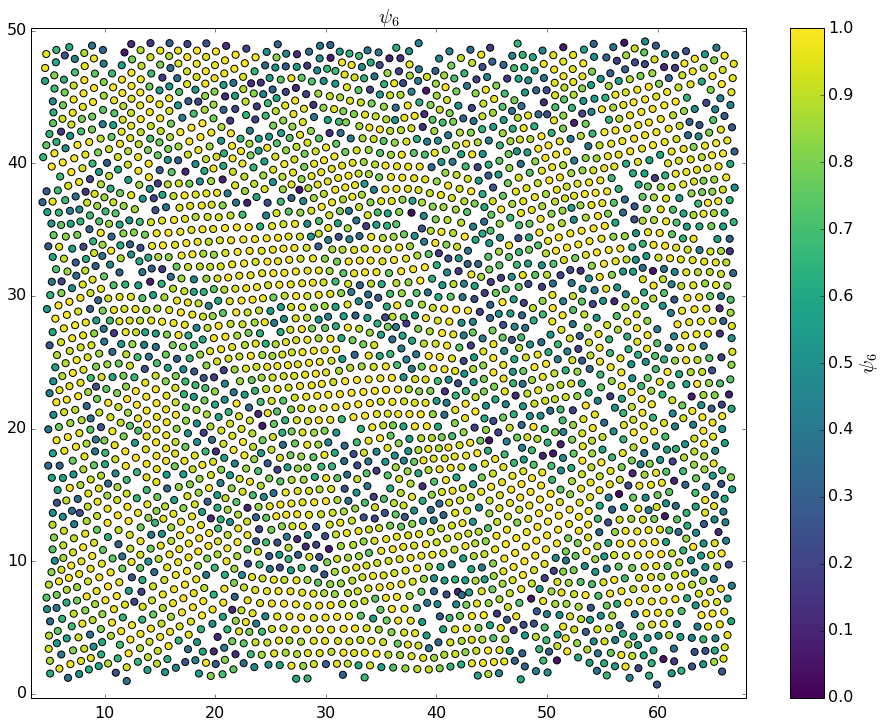

In [8]:
xy_psi6 = psi6(xy)
plt.figure(figsize=(16,12))
plt.title('$\psi_6$',size=20)
plt.scatter(xy[:,0],xy[:,1],vmin=0.0,vmax=1.0,
            c=np.abs(xy_psi6),s=50,cmap=plt.cm.viridis)
plt.xlim(np.nanmin(xy[:,0])-1,np.nanmax(xy[:,0])+1)
plt.ylim(np.nanmin(xy[:,1])-1,np.nanmax(xy[:,1])+1)
cb=plt.colorbar()
cb.set_label(label='$\psi_6$',size=20)
cb.ax.tick_params(labelsize=16)
plt.tick_params(axis='x', pad=8)
plt.tick_params(axis='both', which='major', labelsize=16)

In [7]:
print round(np.mean(np.abs(xy_psi6)),3)

0.756
